## Deep Learning for Human footprint detection

In [1]:
%load_ext autoreload
%autoreload 2
import keras
import cv2
import os
import numpy as np
import pandas as pd
import keras.backend as K
from scripts.unet_utils import M, M_to_RGB, RGB, jaccard_coef, jaccard_coef_int, predict_single_id, predict_id 
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import decode_predictions
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Input, merge, UpSampling2D
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, MaxPool2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from keras.utils import np_utils
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## GLOBAL VARIABLES, RUN THIS CELL
EPOCHS_ex_1 = 1
ISZ = 160
N_Cls = 10
ids_to_show = ['6080_1_3', '6080_4_4', '6100_1_3',
               '6110_2_3', '6140_3_1', '6150_4_0', '6150_4_3']
ids_for_pred = ['6100_1_3', '6140_3_1', '6110_1_2']

## THEORY

## Build a simple Convolutional Neural Network to predict handwritten digits

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
K.set_image_dim_ordering('th')

11493376/11490434 [==============================] - 50s 4us/step


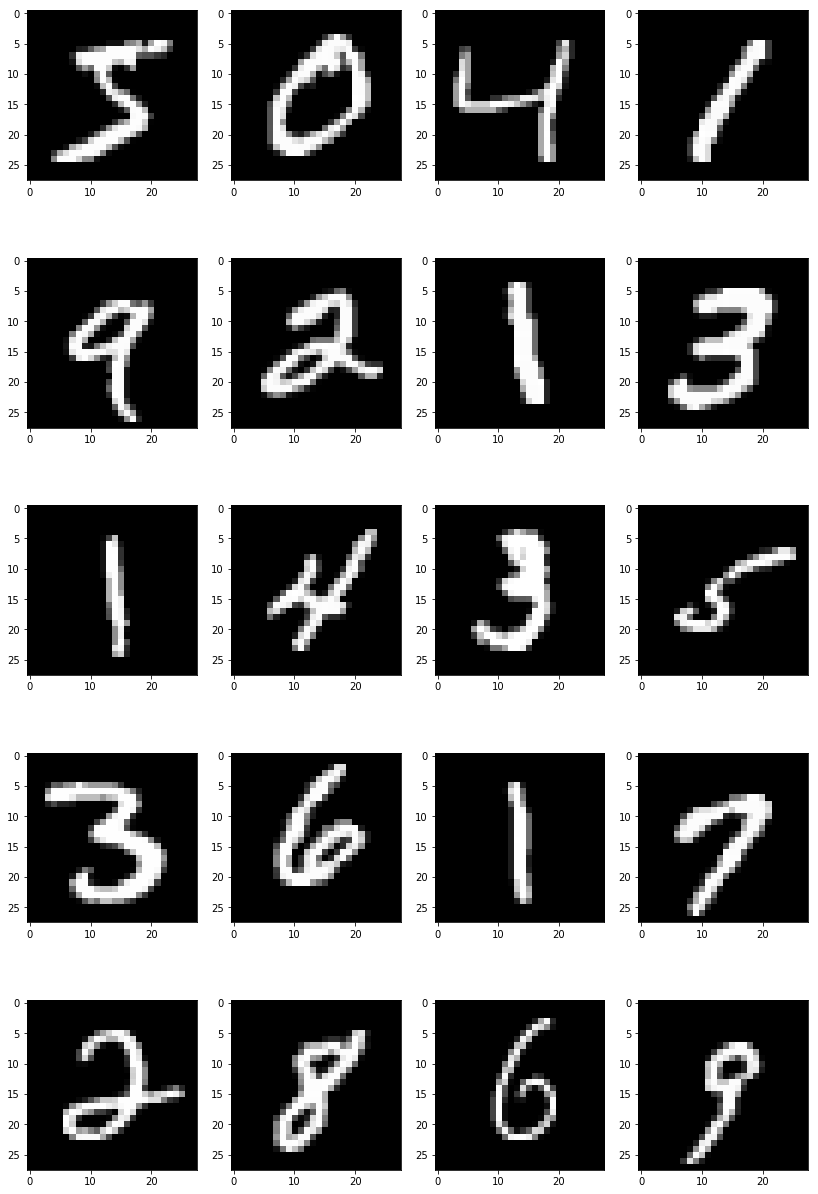

In [4]:
w=10
h=10
fig=plt.figure(figsize=(14, 22))
columns = 4
rows = 5
for i in range(20):
    img = X_train[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap = 'gray')
plt.show()

In [5]:
## RUN THIS CELL
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
INPUT = (1, 28, 28)

** How to add a Convolutional Layer**

In [6]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape = INPUT))

** How to perform max pooling **

In [7]:
model.add(MaxPool2D(pool_size = (2, 2)))

** Perform dropout to speed up training **

In [8]:
model.add(Dropout(0.25))

** Flatten the feature maps for classification **

In [9]:
model.add(Flatten())

**Add a dense layer**

In [10]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

** Add the output layer, with a number of neurons equal to the number of classes **

In [11]:
model.add(Dense(10, activation='softmax'))

**compile the model**

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**fit the model**

In [13]:
model.fit(X_train, Y_train, batch_size = 1024, epochs = 1, verbose=1)

Epoch 1/1
60000/60000 [==============================] - 108s 2ms/step - loss: 0.6607 - acc: 0.7998


In [14]:
#model.save_weights("model_weights_esempio.h5")

**predict and show predictions**

In [15]:
np.random.seed(123)
model.load_weights("weights_/model_weights_esempio.h5")
score = model.evaluate(X_test, Y_test, verbose=0)
print("The loss on test data is: {}. \nThe accuracy on test data is: {}".format(score[0], score[1]))

The loss on test data is: 0.18189694883078336. 
The accuracy on test data is: 0.9484


---

** Below the entire model **

In [16]:
## RUN THIS CELL
K.set_image_dim_ordering('th')
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape = INPUT))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## Data Augmentation

** What if we had just a bunch of images per class? **

** let's pick just the first 40 images **

In [17]:
np.random.seed(123)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train[:40], Y_train[:40], batch_size = 10, epochs = 10, verbose=1)
score = model.evaluate(X_test, Y_test, verbose=0)
print("The loss on test data is: {}. \nThe accuracy on test data is: {}".format(score[0], score[1]))

Epoch 1/10
40/40 [==============================] - 0s 9ms/step - loss: 2.3100 - acc: 0.0750
Epoch 2/10
40/40 [==============================] - 0s 3ms/step - loss: 2.0572 - acc: 0.3500
Epoch 3/10
40/40 [==============================] - 0s 3ms/step - loss: 1.7630 - acc: 0.4500
Epoch 4/10
40/40 [==============================] - 0s 3ms/step - loss: 1.5117 - acc: 0.5750
Epoch 5/10
40/40 [==============================] - 0s 3ms/step - loss: 1.0394 - acc: 0.7250
Epoch 6/10
40/40 [==============================] - 0s 3ms/step - loss: 0.9848 - acc: 0.7500
Epoch 7/10
40/40 [==============================] - 0s 3ms/step - loss: 0.8778 - acc: 0.7250
Epoch 8/10
40/40 [==============================] - 0s 4ms/step - loss: 0.5097 - acc: 0.9250
Epoch 9/10
40/40 [==============================] - 0s 4ms/step - loss: 0.5152 - acc: 0.8000
Epoch 10/10
40/40 [==============================] - 0s 3ms/step - loss: 0.3916 - acc: 0.8750
The loss on test data is: 1.4382708832740783. 
The accuracy on test d

** The accuracy is pretty low on test_data since the network tends to overfit **

In [18]:
np.random.seed(123)
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)
#training the image preprocessing
image_gen.fit(X_train, augment=True)
model.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(), metrics = ['accuracy'])
model.fit_generator(image_gen.flow(X_train[:40], Y_train[:40], batch_size = 10), epochs = 10, steps_per_epoch = 10, verbose = 1)
score = model.evaluate(X_test, Y_test, verbose=0)
print("The loss on test data is: {}. \nThe accuracy on test data is: {}".format(score[0], score[1]))

Epoch 1/10
10/10 [==============================] - 1s 72ms/step - loss: 0.3231 - acc: 0.9000
Epoch 2/10
10/10 [==============================] - 0s 39ms/step - loss: 0.3238 - acc: 0.9000
Epoch 3/10
10/10 [==============================] - 0s 37ms/step - loss: 0.3223 - acc: 0.9000
Epoch 4/10
10/10 [==============================] - 0s 35ms/step - loss: 0.3173 - acc: 0.9000
Epoch 5/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3223 - acc: 0.9000
Epoch 6/10
10/10 [==============================] - 0s 29ms/step - loss: 0.3161 - acc: 0.9000
Epoch 7/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3230 - acc: 0.9000
Epoch 8/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3214 - acc: 0.9000
Epoch 9/10
10/10 [==============================] - 0s 38ms/step - loss: 0.3221 - acc: 0.9000
Epoch 10/10
10/10 [==============================] - 0s 37ms/step - loss: 0.3227 - acc: 0.9000
The loss on test data is: 0.8880296266555786. 
The accuracy

** Accuracy improves a lot on new, unseen data **

---

## How to perform transfer learning

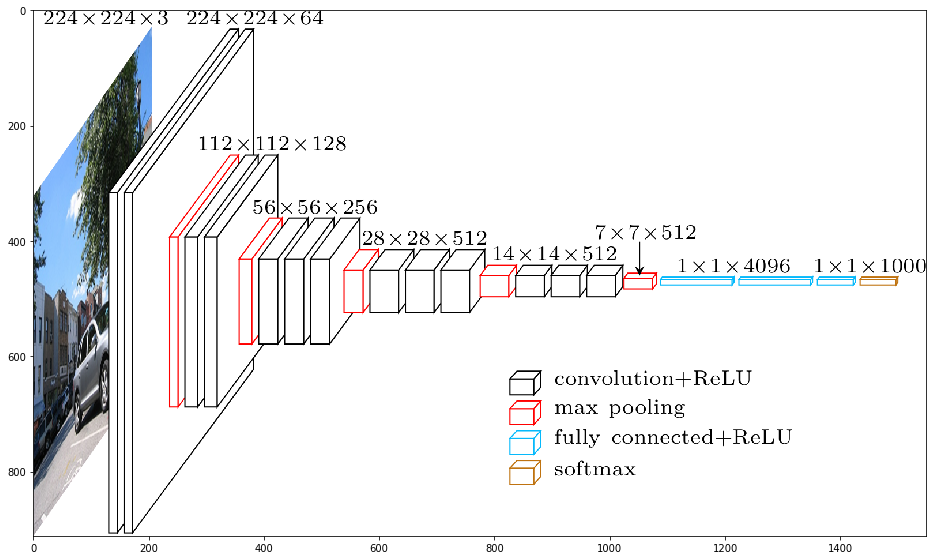

In [19]:
## RUN THIS CELL
img = plt.imread("images_/vgg_16.png")
fig = plt.figure(figsize = (16, 28))
plt.imshow(img)
plt.show()

** (placeholders) **

In [20]:
img_width = 224
img_height = 224
num_of_classes = 10

** include_top = False, we don't want to use the fully connected layers: **

In [21]:
k.set_image_dim_ordering("tf")
model = applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height, 3))

58892288/58889256 [==============================] - 134s 2us/step


** We want to use the pre-defined weights for the feature maps: we won't train them again: **

In [22]:
for layer in model.layers:
    layer.trainable = False

** Let's add our classification part here **

In [23]:
top_layers = model.output
top_layers = Flatten(input_shape=model.output_shape[1:])(top_layers)
top_layers = Dense(num_of_classes, activation="softmax")(top_layers) #single label

** Now let's put the 2 together **

In [24]:
model_final = Model(inputs = model.input, outputs = top_layers)

** From here on we just compile the model as usual, fit and predict it **

---

## Unet for Image Segmentation 

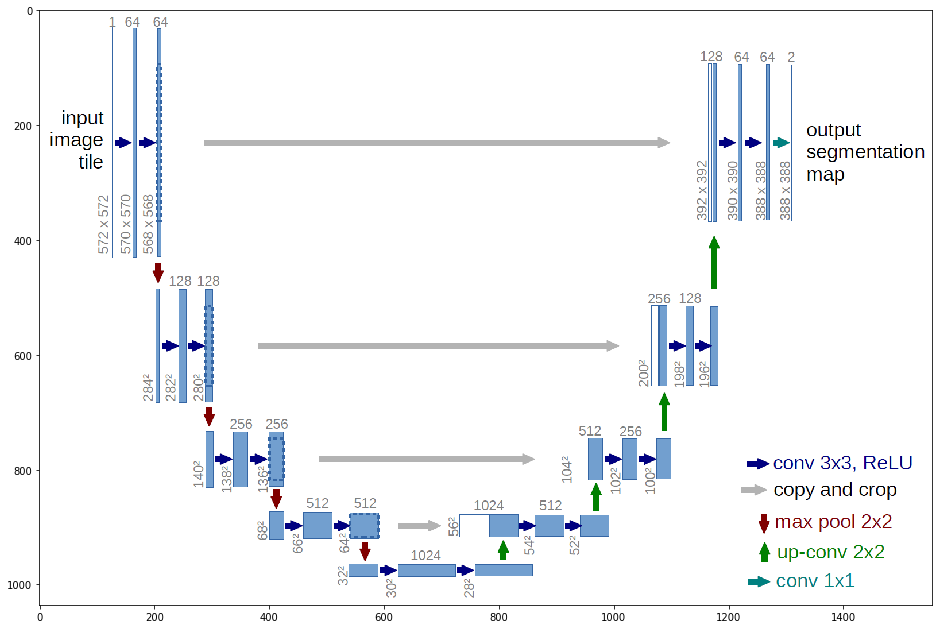

In [25]:
img = plt.imread("images_/unet.png")
fig = plt.figure(figsize = (16, 28))
plt.imshow(img)
plt.show()

** Parameters that we'll need below **

In [29]:
ISZ = 160
inputs = Input((8, ISZ, ISZ))

**Downsampling part**

In [30]:
k.set_image_dim_ordering("th")
conv1 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

In [31]:
pool1.shape

TensorShape([Dimension(None), Dimension(32), Dimension(80), Dimension(80)])

**end of downsampling, start of upsampling **

In [32]:
conv_x = Conv2D(512, (3, 3), activation='relu', padding = 'same')(pool2)
conv_x = Conv2D(512, (3, 3), activation='relu', padding = 'same')(conv_x)

** Upsampling **

In [33]:
up8 = merge([UpSampling2D(size=(2, 2))(conv_x), conv2], mode='concat', concat_axis=1)
conv8 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding = 'same')(conv8)

up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
conv9 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding = 'same')(conv9)

C:\Users\g.dibrino\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
C:\Users\g.dibrino\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\g.dibrino\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [34]:
conv9.shape

TensorShape([Dimension(None), Dimension(32), Dimension(160), Dimension(160)])

** Final 1d convolution to **

In [35]:
conv10 = Conv2D(10, (1, 1), activation='sigmoid')(conv9)

** Notice: **

In [36]:
conv10.get_shape()

TensorShape([Dimension(None), Dimension(10), Dimension(160), Dimension(160)])

** We started from a 160x160 image and we go back to a 160x160 image (x10 i.e. a mask for each class) **

---

## EXERCISES

## 1.a. Build a simple ConvNet in Keras to recognize MNIST handwritten Digits

Referring to section 1.x. build a simple convolutional network with the following layers: 

- convolutional layer with 32 filters and (3, 3) filter size, 'relu' activation
- convolutional layer with 32 filters and (3, 3) filter size, 'relu' activation
- max pooling layer with pool_size (2, 2)
- Add 0.25 Dropout
- Flatten layer
- Add a dense/fully_connected layer with 128 neurons, 'relu' activation
- Add 0.5 Dropout
- Add a dense/fully_connected layer with 10 neurons, 'softmax' activation

---

**Your solution here**

In [37]:
INPUT = (1, 28, 28)
k.set_dim_image_ordering("th")
model_1a = Sequential()
#Continue here

**Complete and compile the model **

In [43]:
model_1a.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

**If your solution is correct you should be able to load the model weigths:**

In [44]:
model_1a.load_weights('weights_/model_weights_1a.h5')

** Evaluate your model: ** 

In [46]:
score = model_1a.evaluate(X_test, Y_test, verbose=0)
print("The loss on test data is: {}. \nThe accuracy on test data is: {}".format(score[0], score[1]))

The loss on test data is: 0.09632521856203675. 
The accuracy on test data is: 0.9707


**Now load a random image and predict it: **

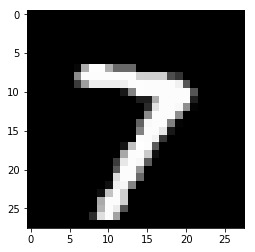

The prediction is: 7


In [47]:
img = X_train[(np.random.randint(60000))]
plt.imshow(img[0], cmap = 'gray')
plt.show()
print("The prediction is: {}".format(np.argmax(model_1a.predict(img.reshape(1, 1, 28, 28))+1)))

## 1.b. Try to improve Accuracy in one of the following ways: 





- Increase the number of convolutional filters in the second conv layer from 32 to 64 (model_1b1)


- Increase the number of neurons in the fully connected layer (Dense) from 128 to 256 (model_1b2)

** Just do one of the two **

In [ ]:
model_1b1 = Sequential()

In [ ]:
model_1b2 = Sequential()

** According to the model chosen execute the corresponding cells among the two below: if your model is correct you should be able to load the weights. **

In [49]:
model = model_1b1
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.load_weights("weights_/model_weights_1b1.h5")

In [52]:
model = model_1b2
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.load_weights("weights_/model_weights_1b2.h5")

In [69]:
## OPTIONAL: REFIT YOUR MODEL.
#np.random.seed(123)
#model.fit(X_train, Y_train, batch_size = 2048, epochs = 1, verbose=1)

In [53]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("The loss on test data is: {}. \n The accuracy on test data is: {}".format(score[0], score[1]))

The loss on test data is: 0.066143034314923. 
 The accuracy on test data is: 0.9795


## 2.a. Transfer Learning: retrain InceptionV3 fully connected layers:

Given the Inception network, retrain the classification part on cats and dogs images. 

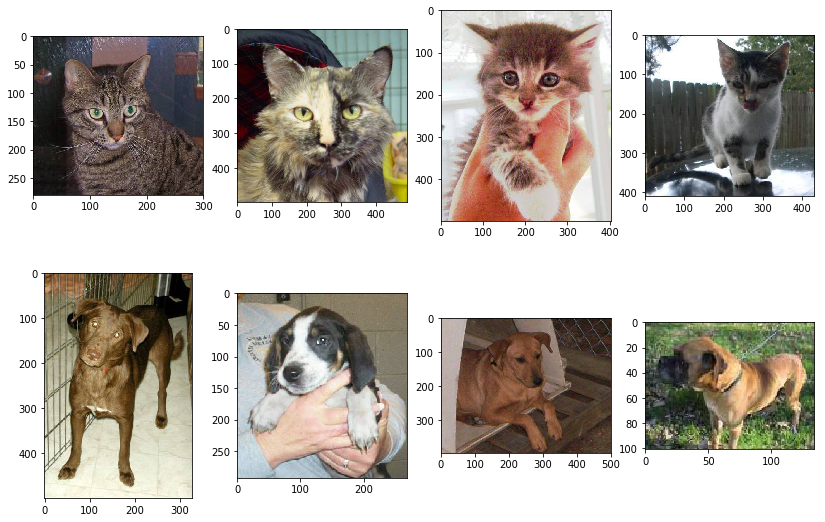

In [94]:
w=10
h=10
fig=plt.figure(figsize=(14, 24))
columns = 4
rows = 5
j = 1
for i in os.listdir("single_label_transfer/train_set/cats/")[:4]:
    img = cv2.cvtColor(cv2.imread("single_label_transfer/train_set/cats/{}".format(i)), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, j)
    j = j+1
    plt.imshow(img)
for i in os.listdir("single_label_transfer/train_set/dogs/")[:4]:
    img = cv2.cvtColor(cv2.imread("single_label_transfer/train_set/dogs/{}".format(i)), cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, j)
    j = j+1
    plt.imshow(img)
plt.show()

In [100]:
#Load training Data
X_train = []
y_train = []
for i in os.listdir("single_label_transfer/train_set/cats"):
    img = cv2.imread(os.path.join("single_label_transfer/train_set/cats", i))
    img = cv2.resize(img, (299, 299))
    X_train.append(img_to_array(img))
    y_train.append(1)
for i in os.listdir("single_label_transfer/train_set/dogs"):
    img = cv2.imread(os.path.join("single_label_transfer/train_set/dogs", i))
    img = cv2.resize(img, (299, 299))
    X_train.append(img_to_array(img))
    y_train.append(0)  
index = np.random.choice(range(0, 200), 200, replace = False) 
X_train = np.array(X_train)[index]
y_train = np.array(y_train)[index]

In [101]:
#Load testing data
X_test = []
y_test = []
for i in os.listdir("single_label_transfer/test_set/cats"):
    img = cv2.imread(os.path.join("single_label_transfer/test_set/cats", i))
    img = cv2.resize(img, (299, 299))
    X_test.append(img_to_array(img))
    y_test.append(1)
for i in os.listdir("single_label_transfer/test_set/dogs"):
    img = cv2.imread(os.path.join("single_label_transfer/test_set/dogs", i))
    img = cv2.resize(img, (299, 299))
    X_test.append(img_to_array(img))
    y_test.append(0)  
index_test = np.random.choice(range(0, 200), 200, replace = False) 
X_test = np.array(X_test)[index_test]
y_test = np.array(y_test)[index_test]

In [102]:
k.set_image_dim_ordering("tf")
model_inception = InceptionV3(input_shape = (299, 299, 3), weights = 'imagenet', include_top=False)

** Create here transfer learning model **

** Make the layers untrainable **

** Take the output from Inception and Flatten it. Call it top_layers as in the example. **

In [131]:
# RUN THIS CELL
top_layers = Dense(1, activation="sigmoid")(top_layers)

C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


** Append the two, choose the loss function and compile the model. **

In [ ]:
model_2a = #
model_2a.compile(loss = "", optimizer = optimizers.Adam(), metrics=["accuracy"])

In [ ]:
## RUN IT 
np.random.seed(123)
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('single_label_transfer/train_set/',
                                                 target_size = (299, 299),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('single_label_transfer/test_set',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'binary')

In [114]:
##Optional, you may just load the weights below
model_2a.fit_generator(training_set,
                         steps_per_epoch = 10,
                         epochs = 2)

** If your model is correct you should be able to download the model weights **

In [ ]:
model_2a.load_weights("weights_/model_weights_2a.h5")
model_2a.evaluate(X_test, y_test, steps = 1)

## 2.b Improve accuracy through data augmentation

In [118]:
model_2b = model_2a
model_2b.load_weights("weights_/model_weights_2a.h5")

** Augment your training data and refit the model **

In [ ]:
train_datagen = ImageDataGenerator()

In [116]:
## You can refit it or download our weights
np.random.seed(123)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('single_label_transfer/train_set/',
                                                 target_size = (299, 299),
                                                 batch_size = 5,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory('single_label_transfer/test_set',
                                            target_size = (299, 299),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
#OPTIONAL, you may just load the weights below
model_2b.fit_generator(training_set,
                         steps_per_epoch = 10,
                         epochs = 2)

model_2b.load_weights("weights_/model_weights_2b.h5")
model_2b.evaluate_generator(test_set, steps = 1)

## 2.c. Transfer Learning: edit code to retrain Inception on Satellite Images

Edit the code to run on a Multilabel problem.

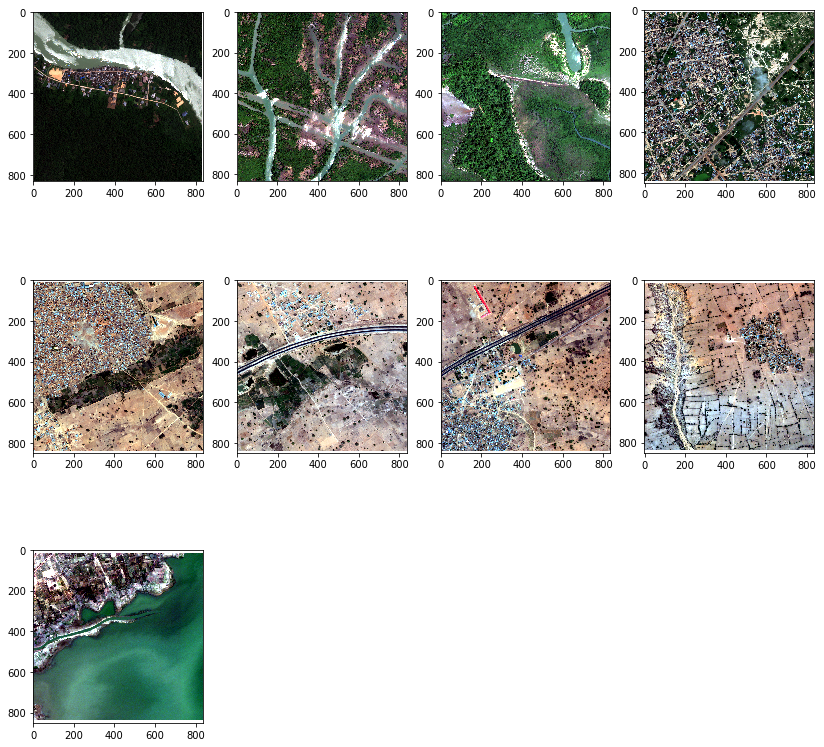

In [68]:
w=10
h=10
fig=plt.figure(figsize=(14, 24))
columns = 4
rows = 5
j = 1
for i in os.listdir("images_/example_images_dstl/"):
    img = plt.imread("images_/example_images_dstl/{}".format(i))
    fig.add_subplot(rows, columns, j)
    j = j+1
    plt.imshow(img)
plt.show()

In [82]:
K.set_image_dim_ordering("tf")
model_inception = InceptionV3(input_shape = (299, 299, 3), weights = 'imagenet', include_top=False)

** Load data: **

In [83]:
##RUN THIS CELL
np.random.seed(123)
df = pd.read_csv("augmented_labels.csv").iloc[:, 1:].set_index('Image_Id', drop = True)
images = []
for i in df.index:
    image = cv2.imread("augmented_images_dstl_multiclass/multilabel/{}.png".format(i))
    image = cv2.resize(image, (299, 299))
    #image = img_to_array(image)
    images.append(image)
features = np.asarray(images)
labels = pd.read_csv("augmented_labels.csv").iloc[:, 1:].set_index('Image_Id', drop = True).values
test_ids = np.random.choice(range(0, 375), 70, replace = False)
train_ids = [i for i in range(375) if i not in test_ids]
x_train = features
y_train = labels
x_train = features[[train_ids]]
y_train = labels[[train_ids]]
x_test = features[test_ids]
y_test = labels[test_ids]

In [77]:
model = model_inception

** Make the convolutional layers untrainable **

** Add our classifier: Flatten and Dense layers with the number of classes considered. Call it 'top_layers' **

** Just execute the cell below **

In [ ]:
model_2c = Model(input = model.input, output = top_layers)

** Select the proper loss and compile the model **

In [ ]:
model_2c.compile(loss = "", optimizer = optimizers.Adam(), metrics=["accuracy"])

** If you did everything right you should be able to load the model weights **

In [ ]:
model_2c.load_weights("weights_/model_weights_2c.h5")

In [91]:
## Optional
#model_2c.fit(x_train, y_train, batch_size = 32, epochs = 2)

In [90]:
model_2c.evaluate(x_test, y_test, verbose=0)

[5.043095765795027, 0.6857143180710928]

## 3.a. Build Unet network, run predictions and see results

Code all the layers in the following function

In [ ]:
def get_unet(): #a non sequential network medeled on U-Net
    #assume stride = 1 unless otherwise specified
    #assume previous layer as input unless otherwise specified
    
    
    inputs = Input((8, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    #conv2 = convolve with 64 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv2 = convolve with 64 3 by 3 filters, ReLU activation and padding keeping the same size
    #pool2 = 2 by 2 MaxPooling

    #conv3 = convolve with 128 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv3 = convolve with 128 3 by 3 filters, ReLU activation and padding keeping the same size
    #pool3 = 2 by 2 MaxPooling

    #conv4 = convolve with 256 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv4 = convolve with 256 3 by 3 filters, ReLU activation and padding keeping the same size
    #pool4 = 2 by 2 MaxPooling

    #conv5 = convolve with 512 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv5 = convolve with 512 3 by 3 filters, ReLU activation and padding keeping the same size
    
    #up6 = concatenate 2 by 2 upsampling of conv5 and conv4
    #conv6 = convolve with 256 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv6 = convolve with 256 3 by 3 filters, ReLU activation and padding keeping the same size

    #up7 = concatenate 2 by 2 upsampling of conv6 and conv3
    #conv7 = convolve with 128 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv7 = convolve with 128 3 by 3 filters, ReLU activation and padding keeping the same size

    #up8 = concatenate 2 by 2 upsampling of conv7 and conv2
    #conv8 = convolve with 64 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv8 = convolve with 64 3 by 3 filters, ReLU activation and padding keeping the same size

    #up9 = concatenate 2 by 2 upsampling of conv8 and conv1
    #conv9 = convolve with 32 3 by 3 filters, ReLU activation and padding keeping the same size
    #conv9 = convolve with 32 3 by 3 filters, ReLU activation and padding keeping the same size

    #Output Layer
    #conv10 = convolve with 10 1 by 1 filters, sigmoid activation

    model = Model(input=inputs, output=conv10)
    #Note: Jaccard coefficient <--> Intersection over Union
    #Select the proper loss function
    model.compile(optimizer = optimizers.Adam(), loss='', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

** You should be able to execute the following cell if your model is correct: **

In [77]:
model.load_weights('weights_/unet_42quality.hdf5')

** Now let's check your predictions: **

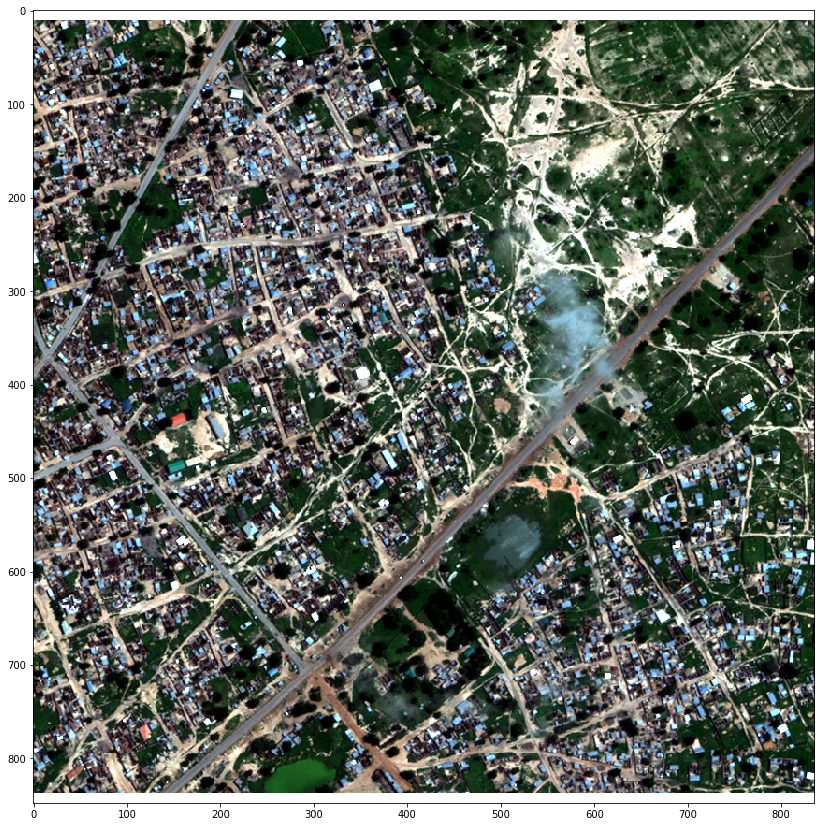

Buildings


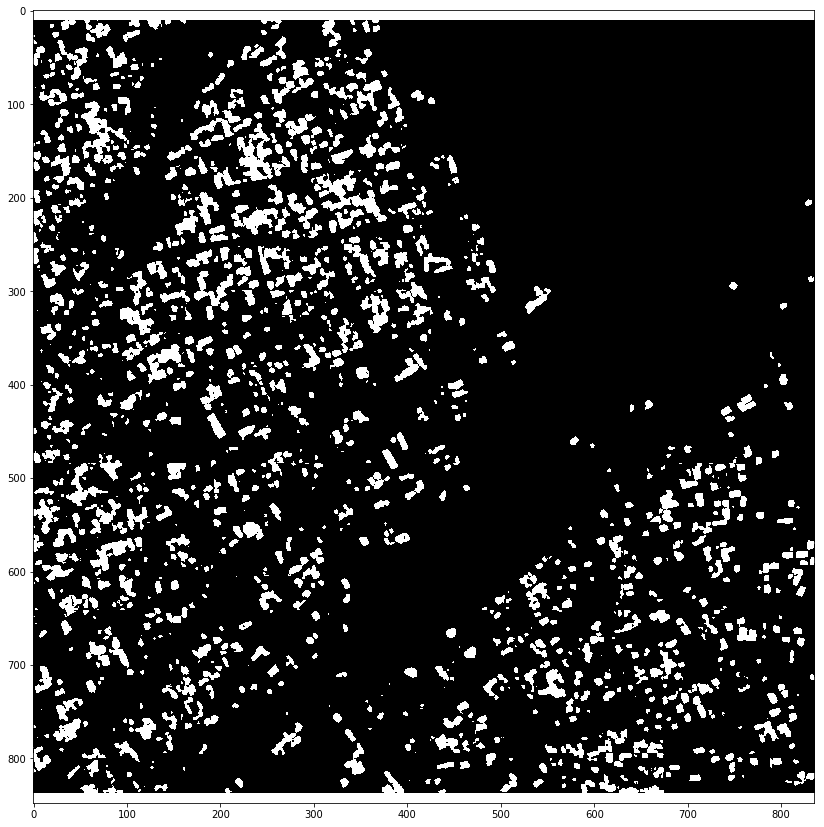

Misc. Manmade Structures


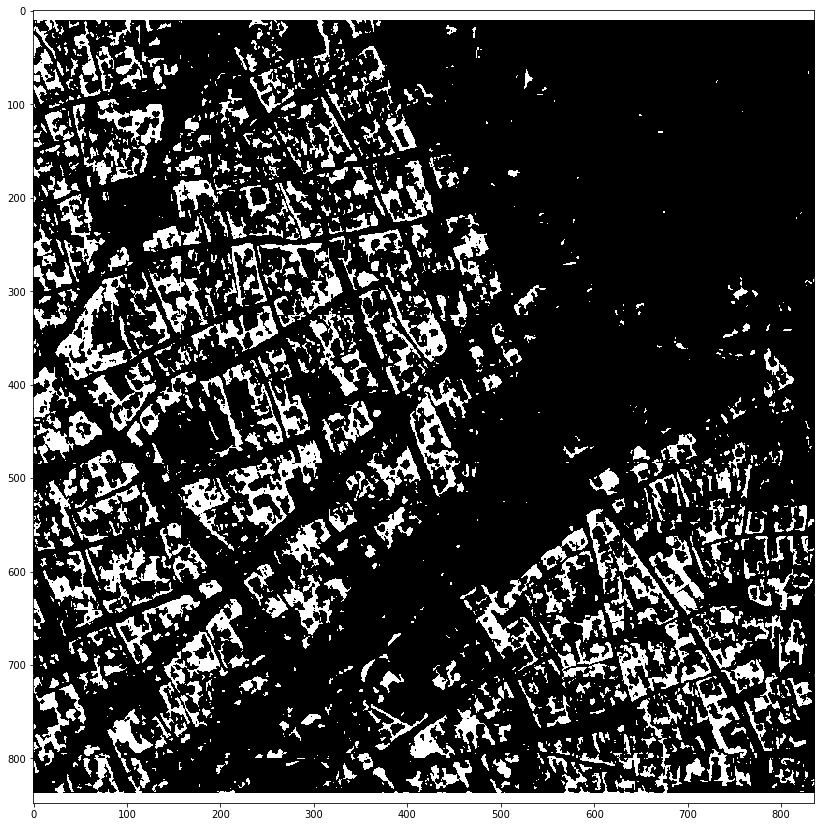

Road


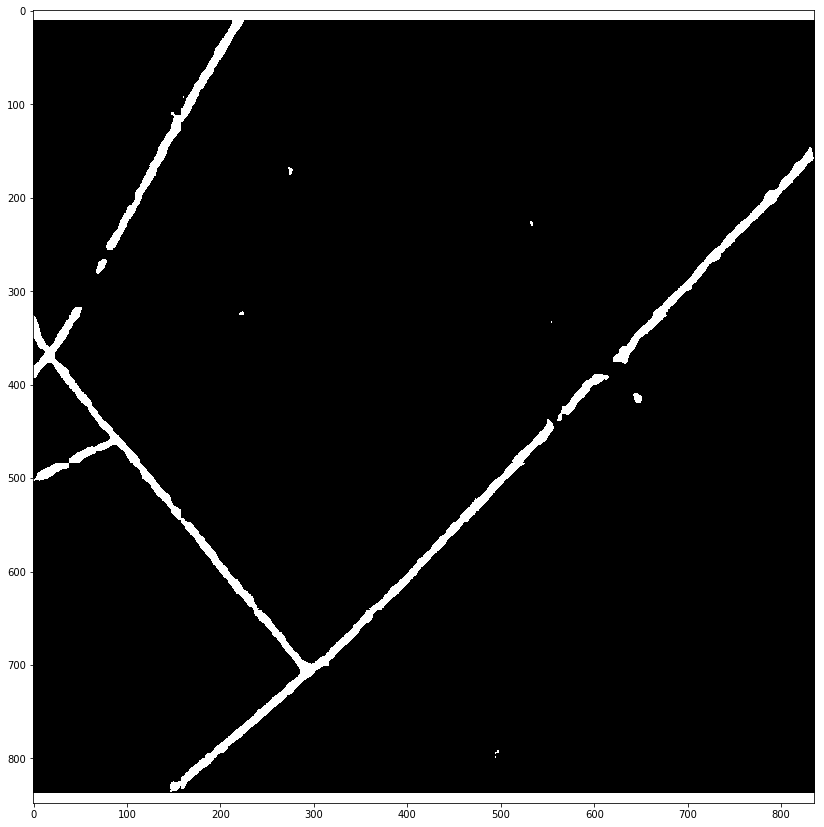

Track


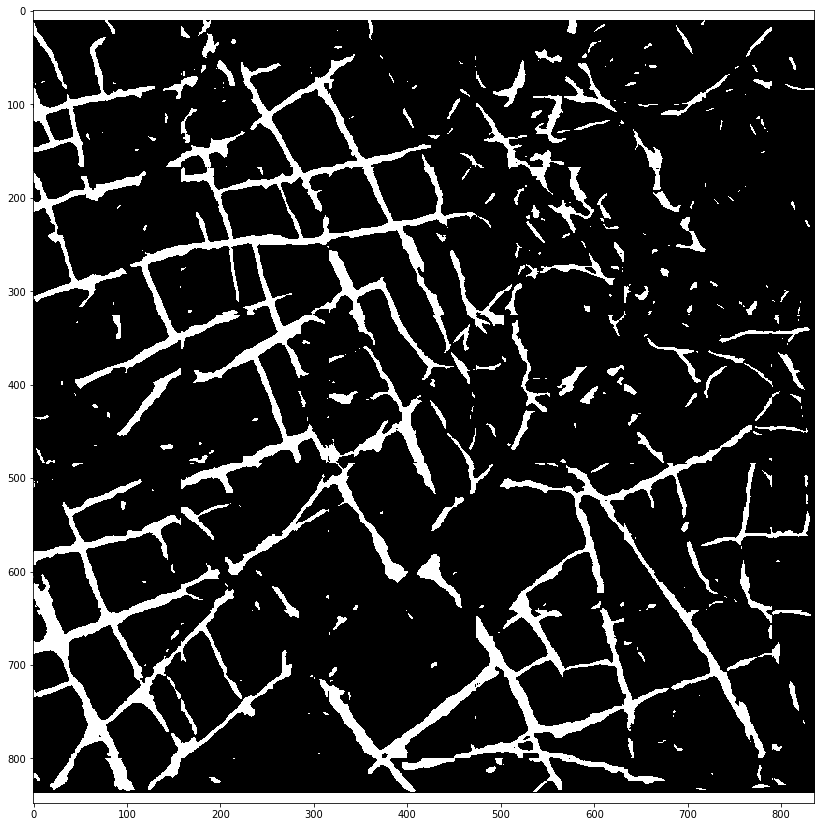

Trees


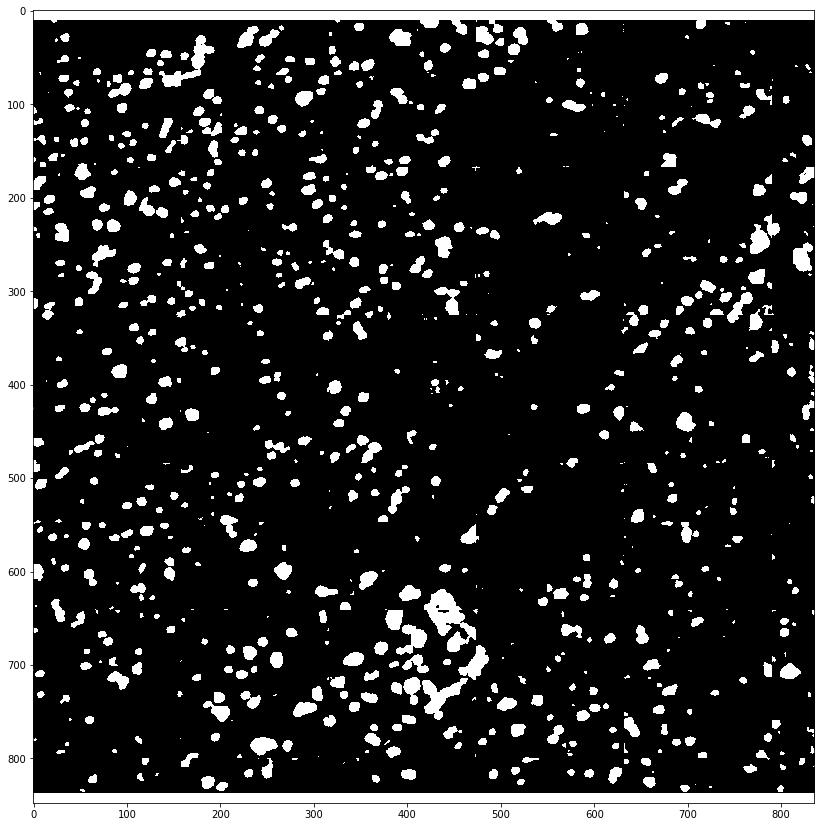

Crops


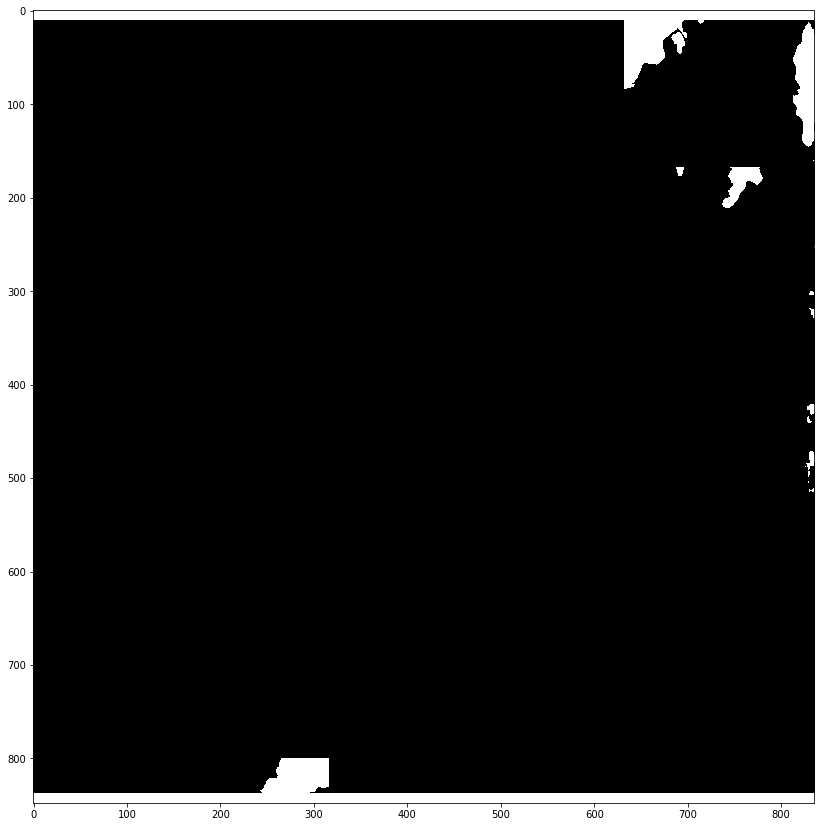

Waterway


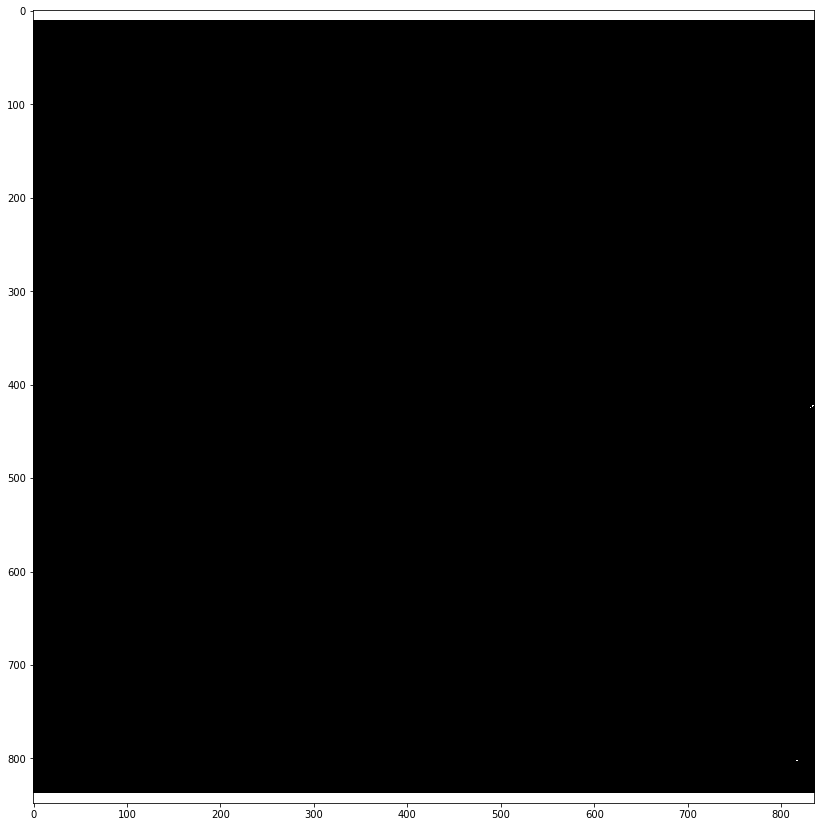

Standing Water


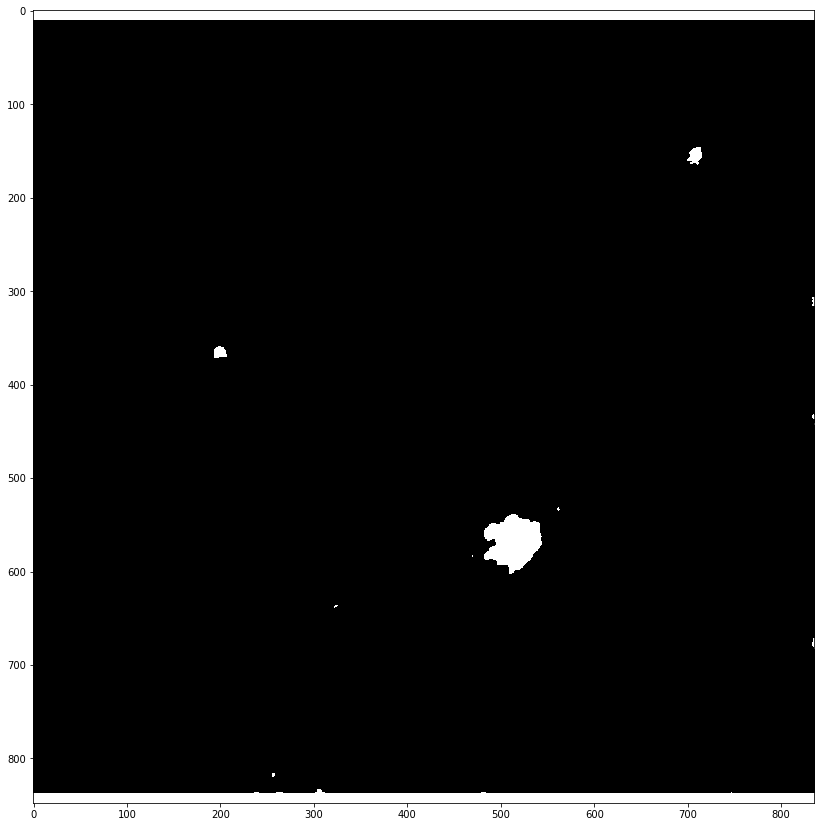

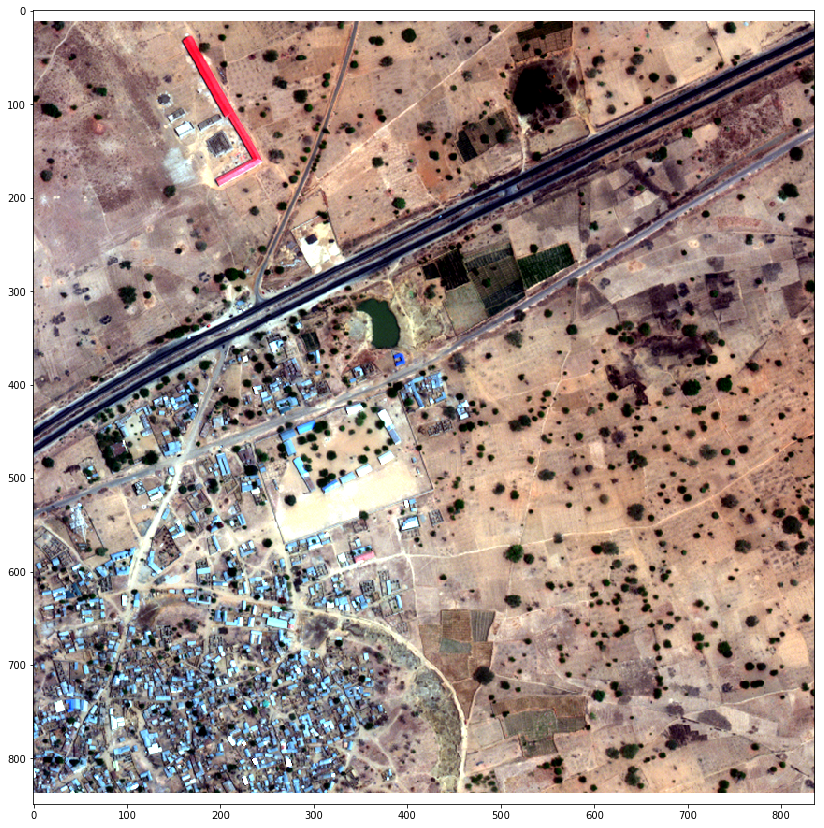

Buildings


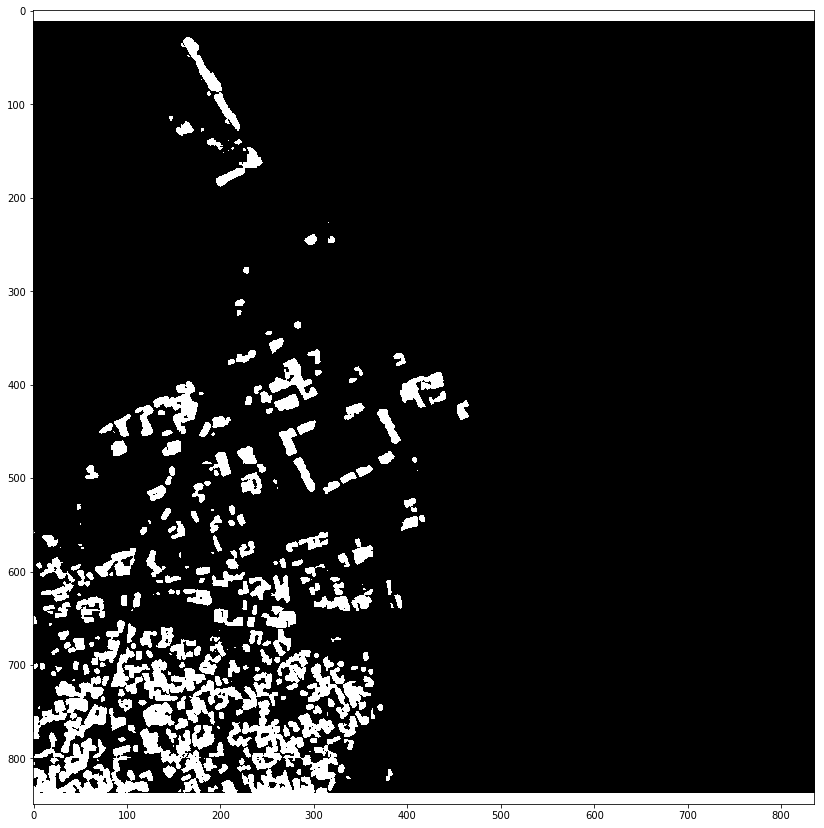

Misc. Manmade Structures


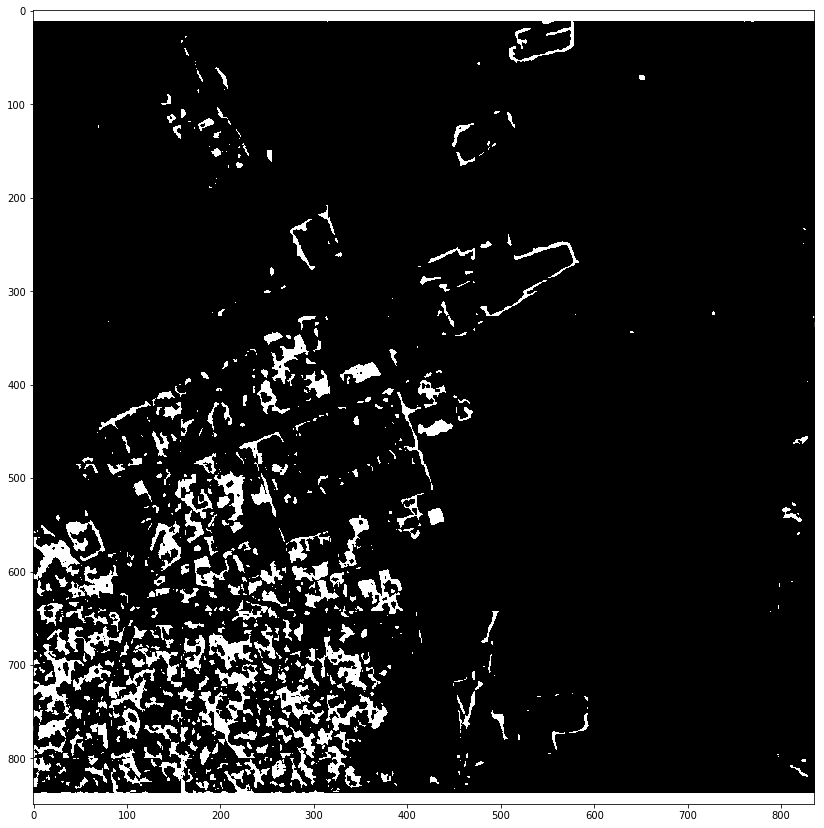

Road


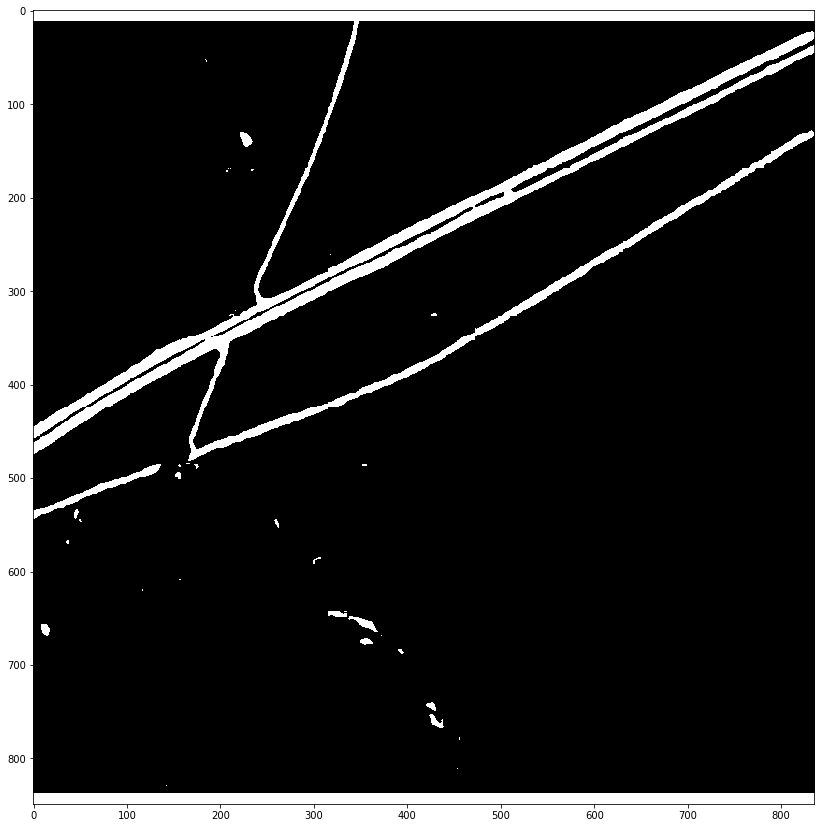

Track


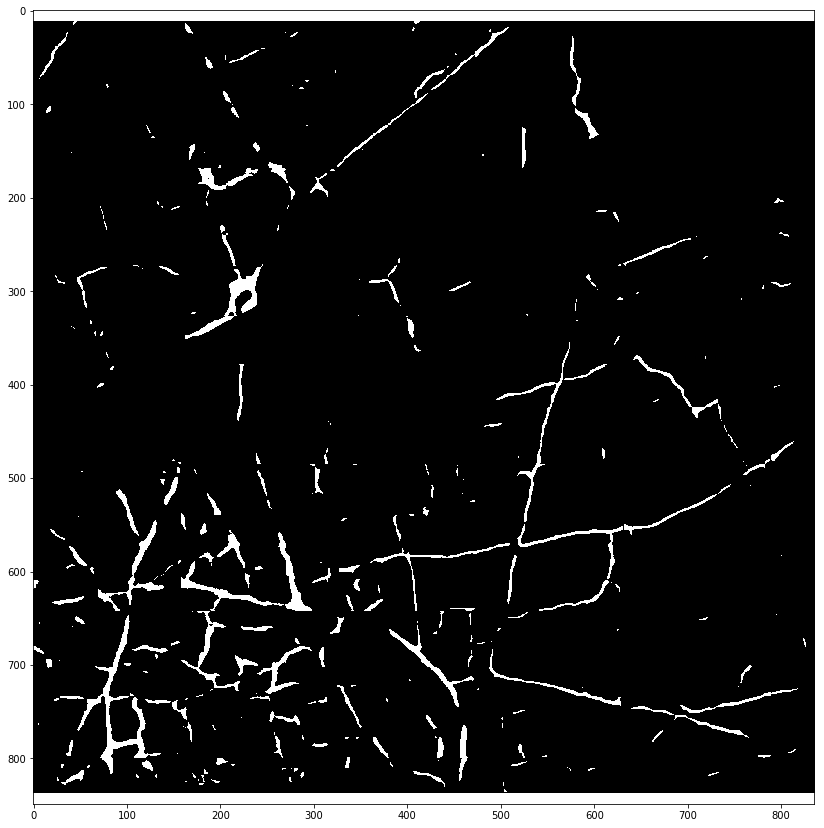

Trees


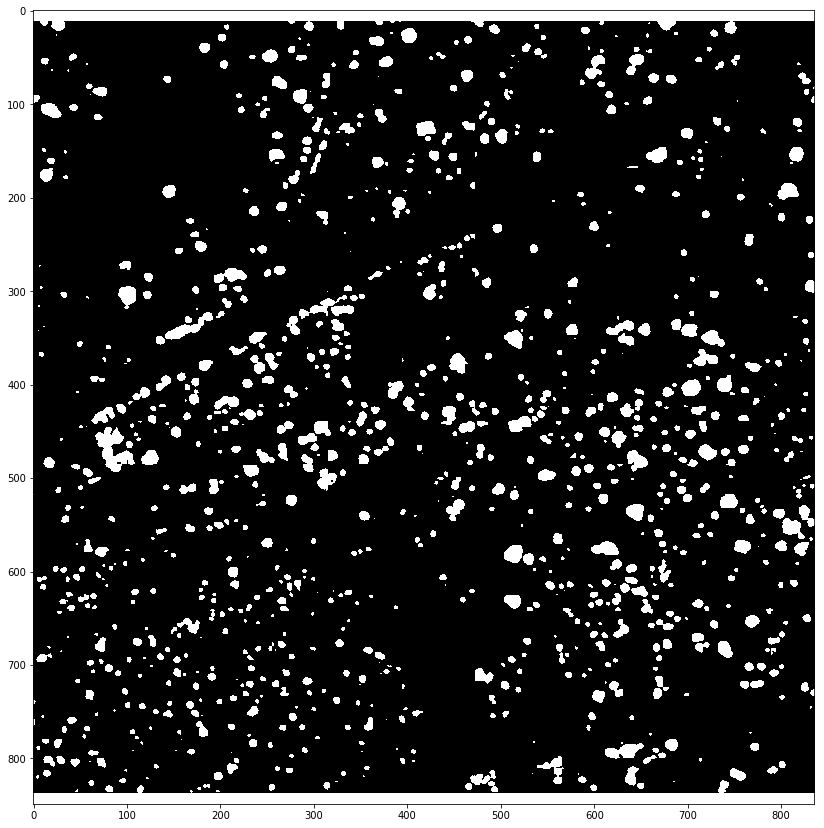

Crops


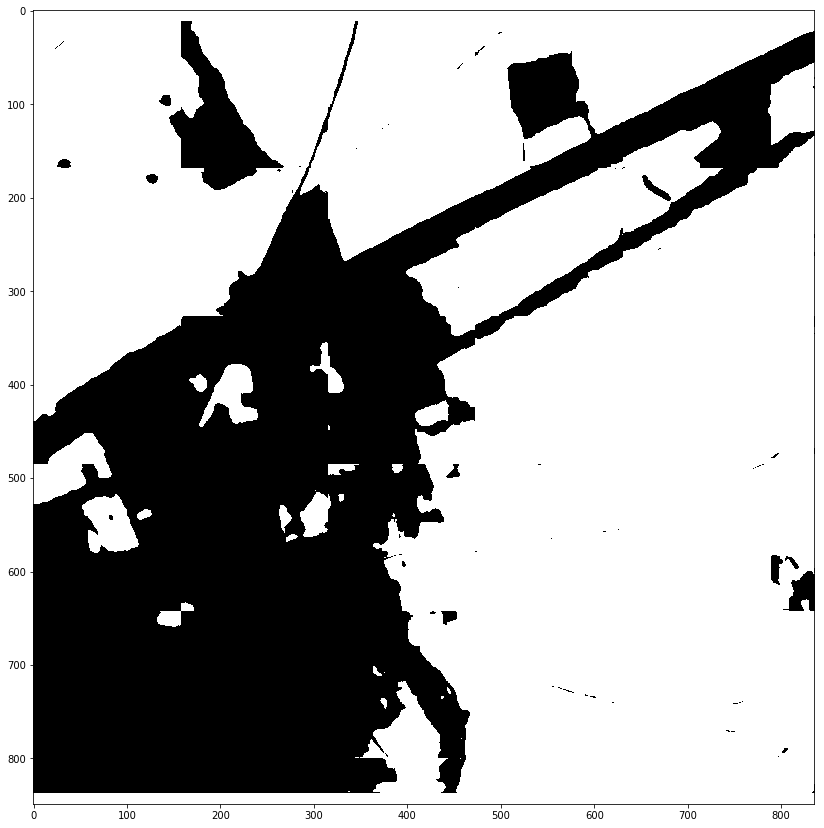

Waterway


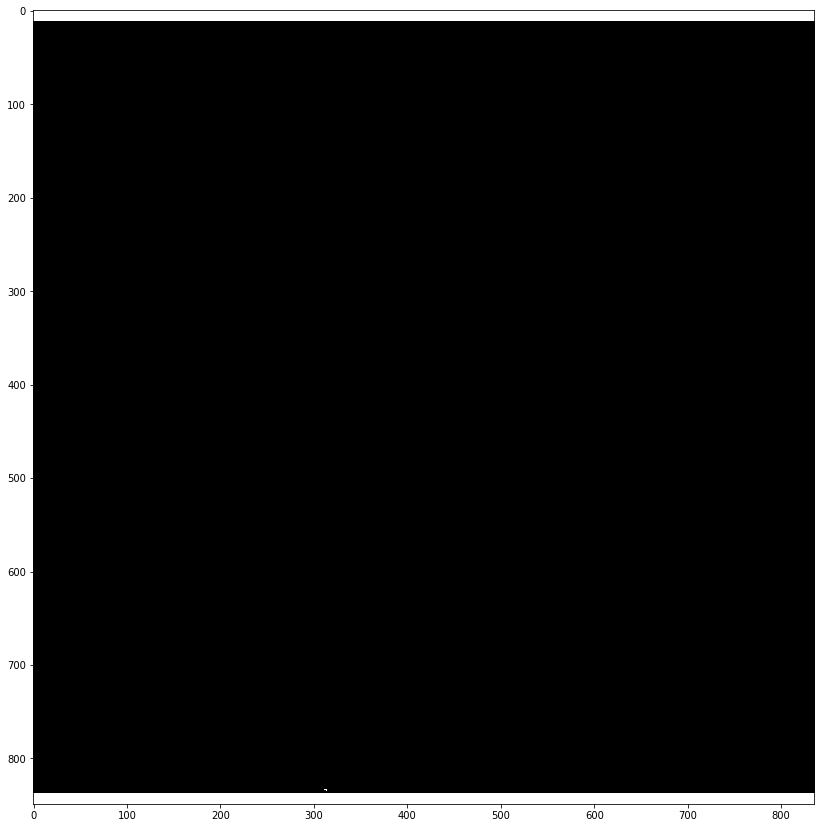

Standing Water


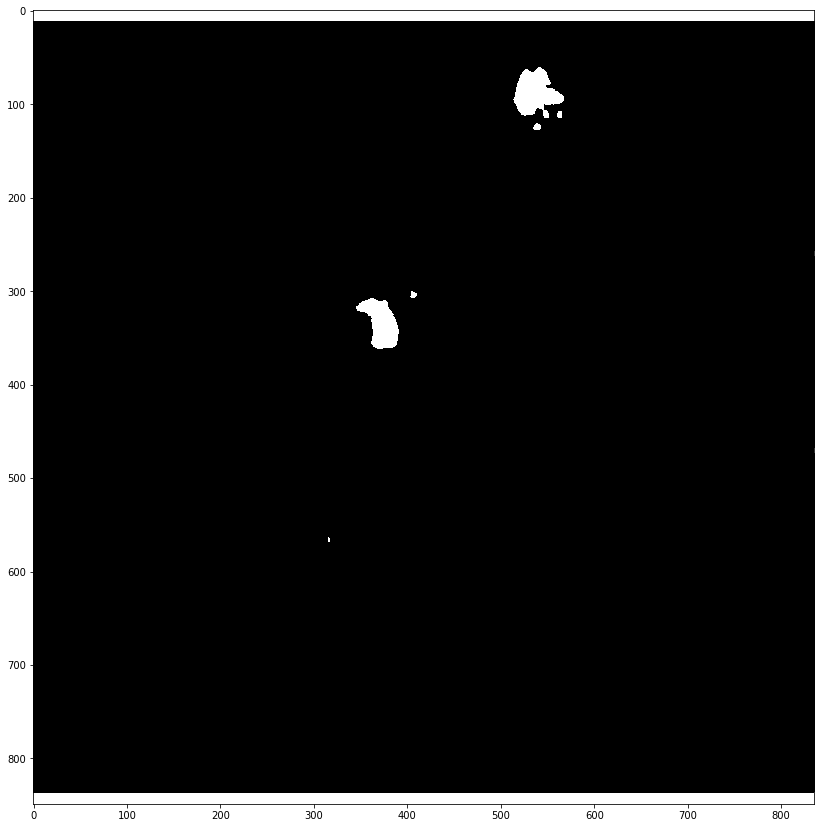

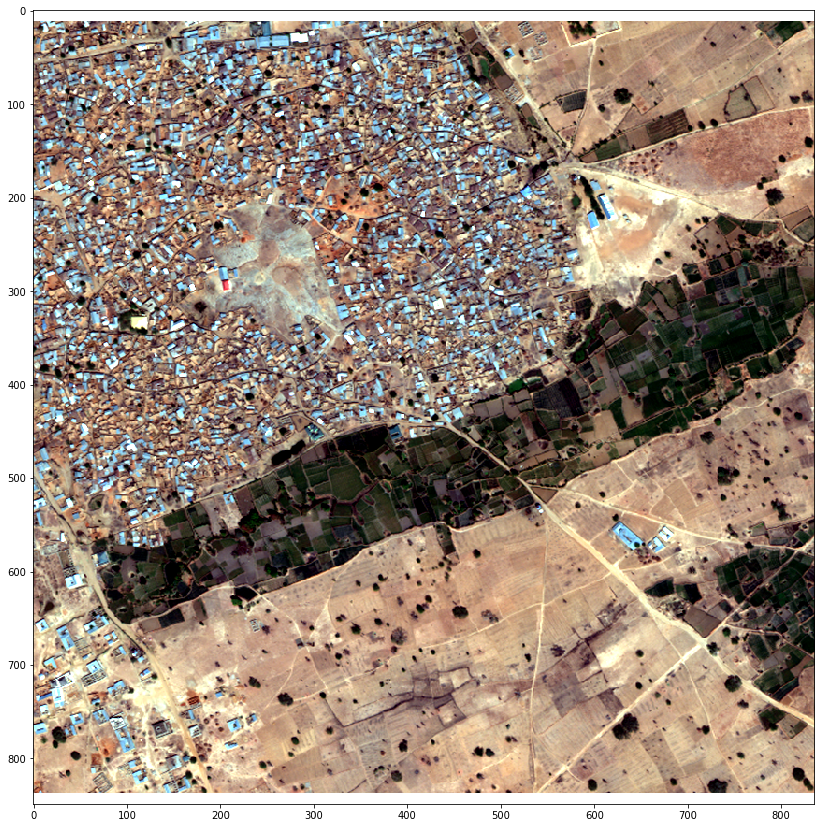

Buildings


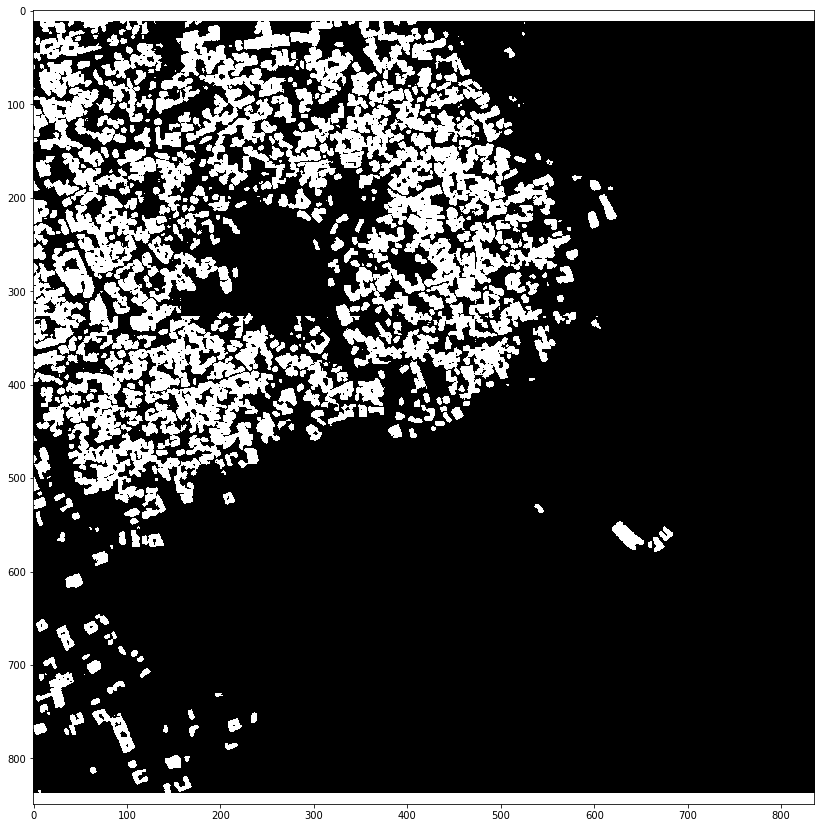

Misc. Manmade Structures


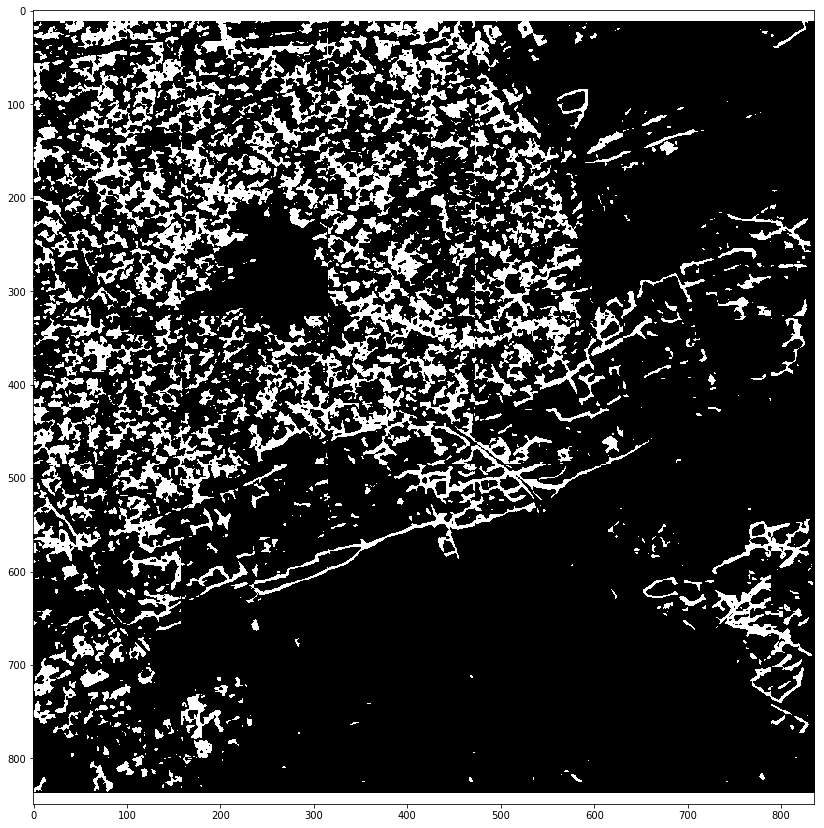

Road


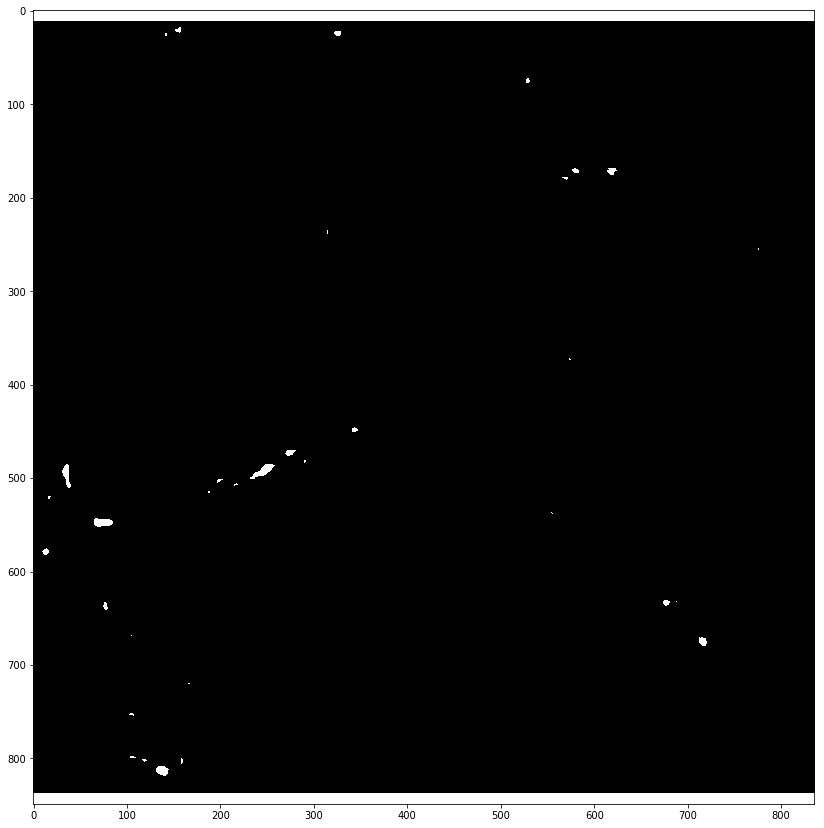

Track


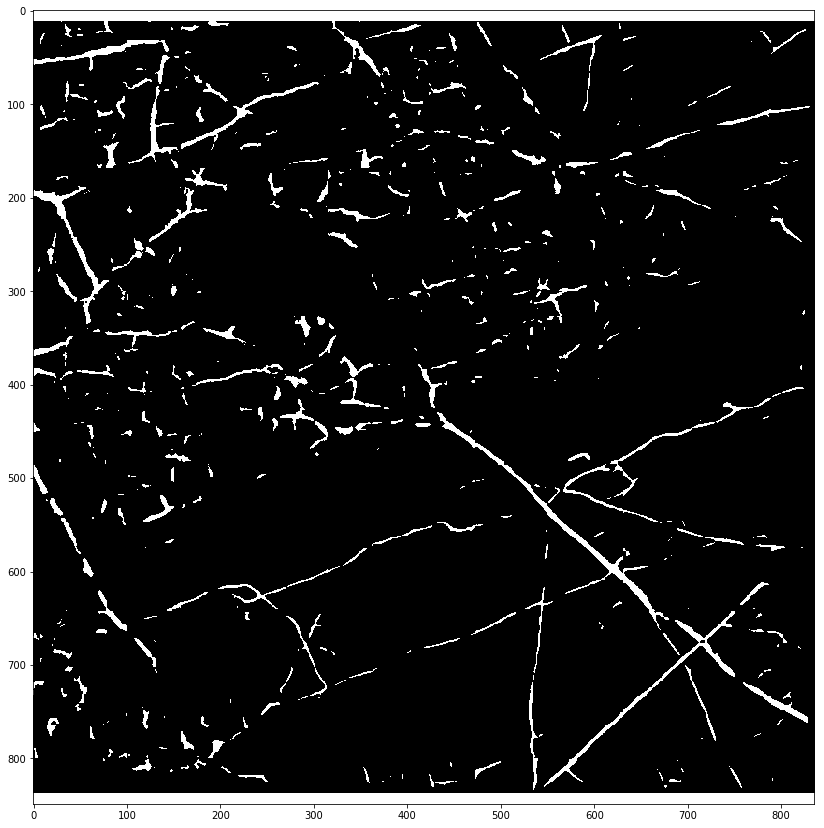

Trees


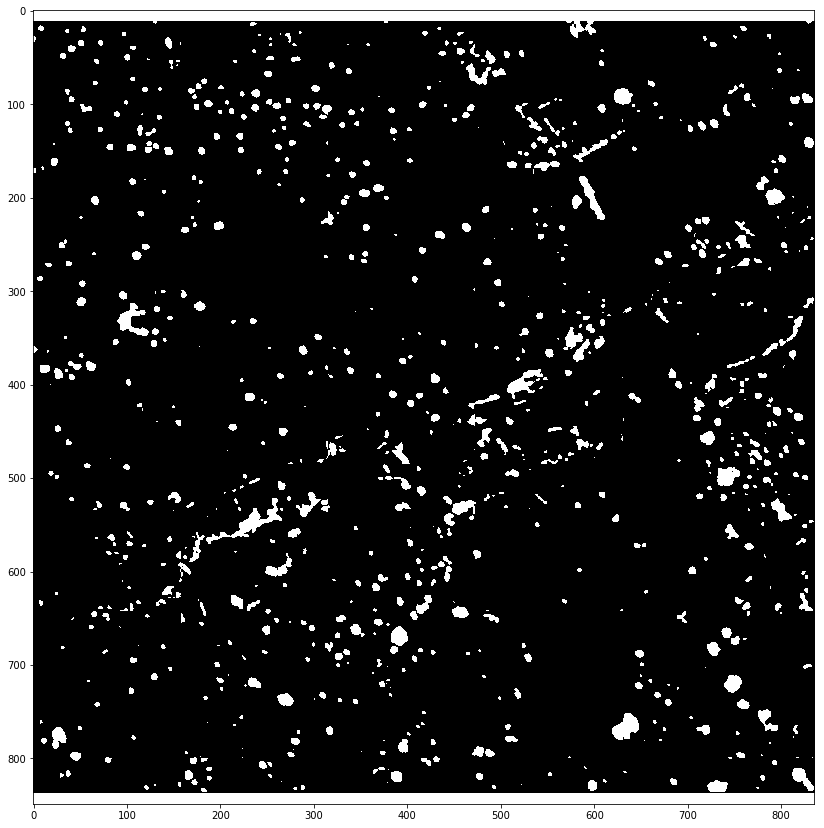

Crops


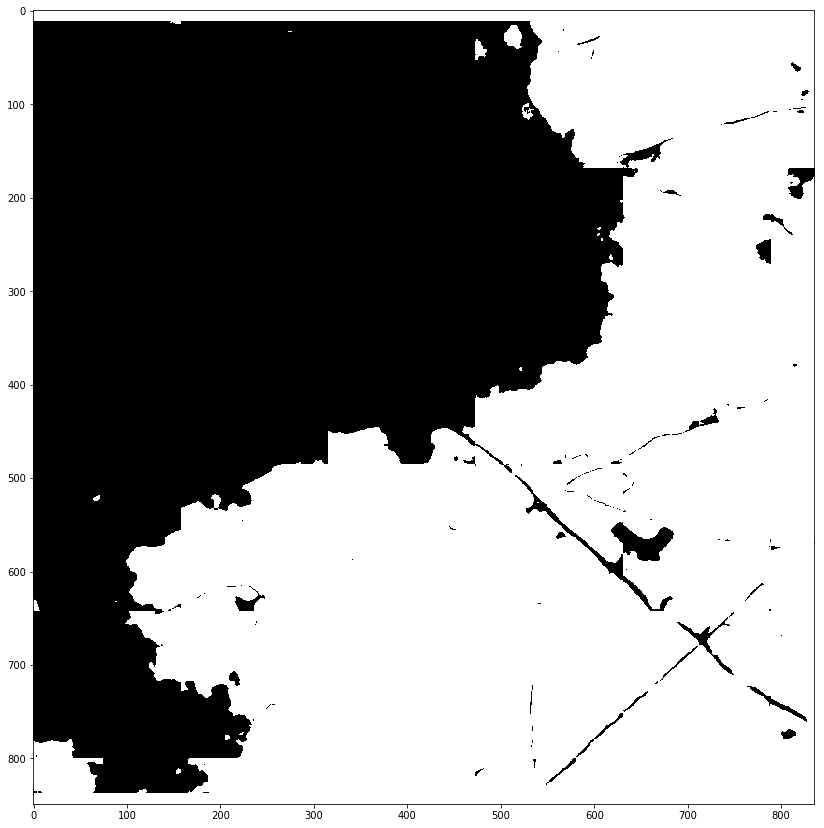

Waterway


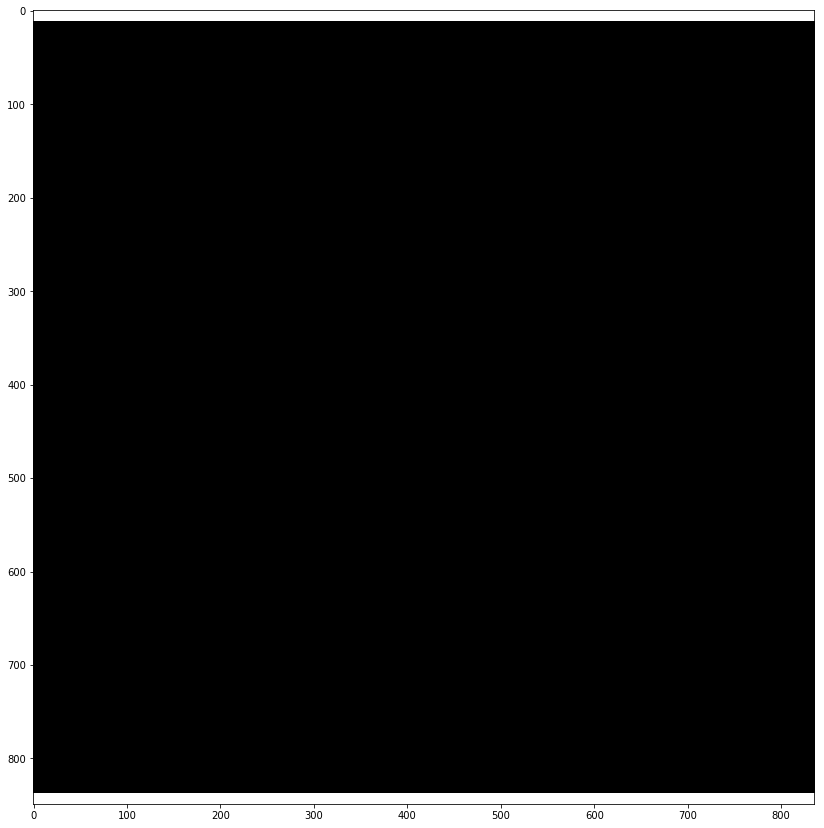

Standing Water


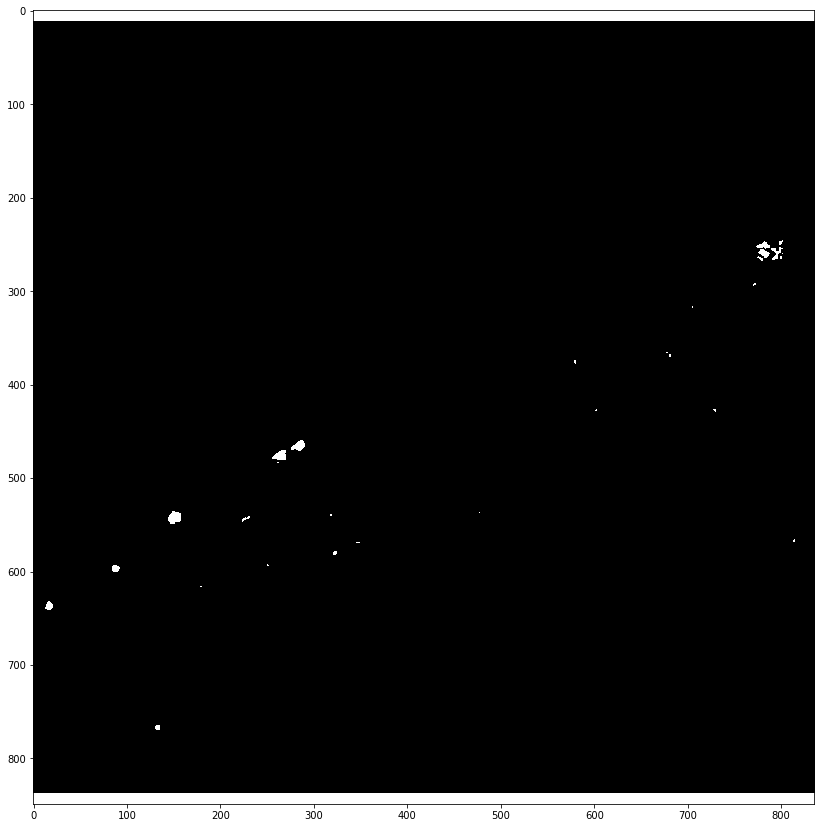

In [79]:
for i in ids_for_pred: 
    predict_single_id(i)

---

## 3. BONUS -- Tensorflow inception retraining

In [23]:
!python -m scripts.retrain_multi_from_repo --bottleneck_dir=tf_files/bottlenecks \
--how_many_training_steps=5 --model_dir=tf_files/models/ --output_graph=tf_files/retrained_for_labcamp.pb \
--image_dir=augmented_images_dstl_multiclass

---

## Solutions to exercises:

## 1.a

In [4]:
INPUT = (1, 28, 28)
k.set_image_dim_ordering("th")
model_1a = Sequential()
model_1a.add(Conv2D(32, (3, 3), activation='relu', input_shape = INPUT))
model_1a.add(Conv2D(32, (3, 3), activation='relu'))
model_1a.add(MaxPool2D(pool_size = (2, 2)))
model_1a.add(Dropout(0.25))
model_1a.add(Flatten())
model_1a.add(Dense(128, activation='relu'))
model_1a.add(Dropout(0.5))
model_1a.add(Dense(10, activation='softmax'))

In [6]:
model_1a.load_weights("weights_/model_weights_1a.h5")

## 1.b.

** 1b1 **

In [48]:
model_1b1 = Sequential()
model_1b1.add(Conv2D(32, (3, 3), activation='relu', input_shape = INPUT))
model_1b1.add(Conv2D(64, (3, 3), activation='relu'))
model_1b1.add(MaxPool2D(pool_size = (2, 2)))
model_1b1.add(Dropout(0.25))
model_1b1.add(Flatten())
model_1b1.add(Dense(128, activation='relu'))
model_1b1.add(Dropout(0.5))
model_1b1.add(Dense(10, activation='softmax'))

** 1b2 **

In [51]:
model_1b2 = Sequential()
model_1b2.add(Conv2D(32, (3, 3), activation='relu', input_shape = INPUT))
model_1b2.add(Conv2D(32, (3, 3), activation='relu'))
model_1b2.add(MaxPool2D(pool_size = (2, 2)))
model_1b2.add(Dropout(0.25))
model_1b2.add(Flatten())
model_1b2.add(Dense(256, activation='relu'))
model_1b2.add(Dropout(0.5))
model_1b2.add(Dense(10, activation='softmax'))

## 2.a

In [103]:
for layer in model_inception.layers:
    layer.trainable = False

In [104]:
top_layers = model_inception.output
top_layers = Flatten(input_shape=model_inception.output_shape[1:])(top_layers)
top_layers = Dense(1, activation = 'sigmoid')(top_layers)

In [105]:
model_2a = Model(inputs = model_inception.input, outputs = top_layers)
model_2a.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

## 2.b

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

## 2.c

In [84]:
for layer in model_inception.layers:
    layer.trainable = False

In [85]:
top_layers = model_inception.output
top_layers = Flatten(input_shape=model_inception.output_shape[1:])(top_layers)
top_layers = Dense(5, activation = 'sigmoid')(top_layers)

In [86]:
model_2c = Model(inputs = model_inception.input, outputs = top_layers)
model_2c.compile(loss = "binary_crossentropy", optimizer = optimizers.Adam(), metrics=["accuracy"])

## 3

In [81]:
K.set_image_dim_ordering("th")
inputs = Input((8, ISZ, ISZ))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print("conv5 has shape {}".format(conv5.get_shape))
up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=inputs, outputs=conv10)
model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

conv5 has shape <bound method Tensor.get_shape of <tf.Tensor 'conv2d_271/Relu:0' shape=(?, 512, 10, 10) dtype=float32>>


C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\t.guerrini\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras